# <p style='text-align: justify;'> Churn prediction </p>
<p style='text-align: justify;'> Churn prediction is difficult. Before you can do anything to prevent customers leaving, you need to know everything from who’s going to leave and when, to how much it will impact your bottom line. In this post I’m going to explain some techniques for churn prediction and prevention using survival analysis. </p>

# <p style='text-align: justify;'> Dataset </p>
<p style='text-align: justify;'> The dataset we’ll be using is the Kaggle Telco Churn dataset ( available <a href="https://www.kaggle.com/c/telco-churn/data">here</a>), it contains a little over 7,000 customer records and includes features such as the customer’s monthly spend with the company, the length of time (in months) that they’ve been customers, and whether or not they have various internet service add-ons. </p>

### <p style='text-align: justify;'> Preliminaries </p>
<p style='text-align: justify;'> In the previous section, I already mentioned using of survival analysis as a theoritical framework but the natural question migh raise would be, What is the survival analysis?. Answering to this quite simple question might not be easy at all because there are very solid theoritical background for the survival analysis and its pros and cons as well as its application in a real-life problems. However, inorder to have a feelling and having the hands dirty on, I will try to briefly give some information regarding the survival analysis. In the following I will present a very brief introduction to the survival function which is borrowed fro <a href="https://thomaselove.github.io/432-notes/exploring-time-to-event-survival-data.html">here</a>.</p>

* <p style='text-align: justify;'> Survival analysis theory </p>

#### <p style='text-align: justify;'> Introduction to survival analysis </p>
<p style='text-align: justify;'> Survival analysis is a collection of methods to analyse time to event data. A key part of survival analysis is the modeling of the contribution of censored observations to model likelihood. Censored observations are those for which we have not observed the event (also called right-censoring). The event could be the death of a patient, diagnosis of a disease, failure of a machine part and in this analysis, it is defined as the end of terrorist groups. In the dataset that we will use, not all terrorist groups ended until the end of the observation period. Survival analysis is a suitable method to analyze the factors that influence the time to end of these groups. One very important assumption of survival analysis is that the time to event for censored terror groups does not systematically differ from those whose end we have observed. </p>

##### <p style='text-align: justify;'> Applications </p>

<p style='text-align: justify;'> Traditionally, survival analysis was developed to measure lifespans of individuals. An actuary or health professional would ask questions like "how long does this population live for?", and answer it using survival analysis. For example, the population may be a nation's population (for actuaries), or a population stricken by a disease (in the medical professional's case). Traditionally, sort of a morbid subject.</p>

<p style='text-align: justify;'> But survival analysis can be applied to not only births and deaths, but any duration. Medical professionals might be interested in the time between childbirths, where a birth in this case is the event of having a child, and a death is becoming pregnant again! (obviously, we are loose with our definitions of birth and death) Another example is users subscribing to a service: a birth is a user who joins the service, and a death is when the user leaves the service. </p>

##### <p style='text-align: justify;'> Censoring </p>

<p style='text-align: justify;'> At the time you want to make inferences about durations, it is possible that not all the death events have occurred yet. For example, a medical professional will not wait 50 years for each individual in the study to pass away before investigating -- he or she is interested in making decisions after only a few years, or months possibly. </p>

<p style='text-align: justify;'> The individuals in a population who have not been subject to the death event are labeled as right-censored, i.e., we did not (or can not) view the rest of their life history due to some external circumstances. All the information we have on these individuals are their current lifetime durations (which is naturally less than their actual lifetimes). </p>


Note

There is also left-censoring and interval censoring, which are expanded on later.

<p style='text-align: justify;'> A common mistake data analysts make is choosing to ignore the right-censored individuals. We will see why this is a mistake next.</p>

<p style='text-align: justify;'> Consider a case where the population is actually made up of two subpopulations, A and B. Population A has a very small lifespan, say 2 months on average, and population B enjoys a much larger lifespan, say 12 months on average. We don't know this distinction beforehand. At t=10, we wish to investigate the average lifespan for the entire population.</p>

<p style='text-align: justify;'> In the figure below, the red lines denote the lifespan of individuals where the death event has been observed, and the blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). If we are asked to estimate the average lifetime of our population, and we naively decided to not included the right-censored individuals, it is clear that we would be severely underestimating the true average lifespan.</p>

Observed lifetimes at time 10:
 [ 4.91871533  0.59570742 10.          1.25658527  2.30097954  2.30025806
  0.8404924   3.80212039 10.         10.          1.63240642  2.70136307
  3.0882886   6.85584479 10.          8.91934326  5.73879263  1.8935336
  1.64411842  4.49862728  9.7005602   0.75348536  0.83901481  1.36069761
 10.        ]


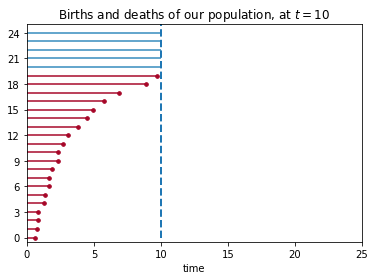

In [1]:
from lifelines.plotting import plot_lifetimes
import numpy as np
from numpy.random import uniform, exponential

N = 25

CURRENT_TIME = 10

actual_lifetimes = np.array([
    exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)
])
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)

ax.set_xlim(0, 25)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Births and deaths of our population, at $t=10$")
print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

<p style='text-align: justify;'> Example lifetimes of individuals. We only observe up to time 10, but the blue individuals have not died yet (i.e. they are censored).</p>

<p style='text-align: justify;'> Furthermore, if we instead simply took the mean of all lifespans, including the current lifespans of right-censored instances, we would still be underestimating the true average lifespan. Below we plot the actual lifetimes of all instances (recall we do not see this information at t=10). </p>

(0.0, 25.0)

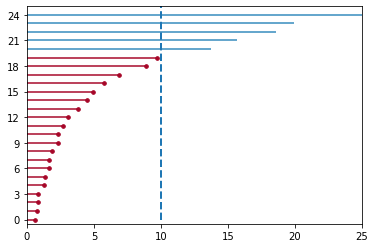

In [2]:
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlim(0, 25)

<p style='text-align: justify;'> Revealing the actual lifetimes of individuals. </p>


<p style='text-align: justify;'> Survival analysis was originally developed to solve this type of problem, that is, to deal with estimation when our data is right-censored. However, even in the case where all events have been observed, i.e. there is no censoring, survival analysis is still a very useful tool to understand durations and rates. </p>

<p style='text-align: justify;'> The observations need not always start at zero, either. This was done only for understanding in the above example. Consider the example where a customer entering a store is a birth: a customer can enter at any time, and not necessarily at time zero. In survival analysis, durations are relative: individuals may start at different times. (We actually only need the duration of the observation, and not necessarily the start and end time.) </p>

<p style='text-align: justify;'> We next introduce the three fundamental objects in survival analysis, the survival function, hazard function and the cumulative hazard function. </p>

##### <p style='text-align: justify;'> Survival function </p>

<p style='text-align: justify;'> Let T be a (possibly infinite, but always non-negative) random lifetime taken from the population under study. For example, the amount of time a couple is married. Or the time it takes a user to enter a webpage (an infinite time if they never do). The survival function - $S(t)$ - of a population is defined as </p>

$$ S(t) = Pr(T > t)$$


<p style='text-align: justify;'> Simply, the survival function defines the probability the death event has not occurred yet at time t, or equivalently, the probability of surviving past time t. Note the following properties of the survival function: </p>


<p style='text-align: justify;'> Simply, the survival function defines the probability the death event has not occurred yet at time t, or equivalently, the probability of surviving past time t. Note the following properties of the survival function: </p>

* <p style='text-align: justify;'> $0 \le S(t) \le 1$ </p>
* <p style='text-align: justify;'> $F(t) = 1 - S(t)$, where $F(t)$ is the CDF of T, which implies</p>
* <p style='text-align: justify;'> $S(t)$ is a non-increasing function of t. </p>
<p style='text-align: justify;'> Here's an example of a survival function: </p>





![intro_survival_function.png](attachment:intro_survival_function.png)


<p style='text-align: justify;'> Reading from this graph, we can see that at time 40, about 75% of the population is still alive.</p>


##### <p style='text-align: justify;'> Hazard function </p>

<p style='text-align: justify;'> We are also interested in the probability of the death event occurring at time t, given that the death event has not occurred yet. Mathematically, that is: </p>

$$\lim_{\delta t \rightarrow 0 } \; Pr( t \le T \le t + \delta t | T > t)$$


<p style='text-align: justify;'> This quantity goes to 0 as $\delta t$ shrinks, so we divide this by the interval $\delta t$ (like we might do in calculus). This defines the hazard function at time $t$, $h(t)$: </p>

$$h(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t}$$

It can be shown that this is equal to:

$$h(t) = \frac{-S'(t)}{S(t)}$$

and solving this differential equation (cool, it is a differential equation!), we get:

$$S(t) = \exp\left( -\int_0^t h(z) \mathrm{d}z \right)$$

The integral has a more common name: the cumulative hazard function, denoted $H(t)$. We can rewrite the above as:

$$S(t) = \exp\left(-H(t) \right)$$

With that, the two figures below represent the hazard and the cumulative hazard, respectively, of the survival function in the figure above.

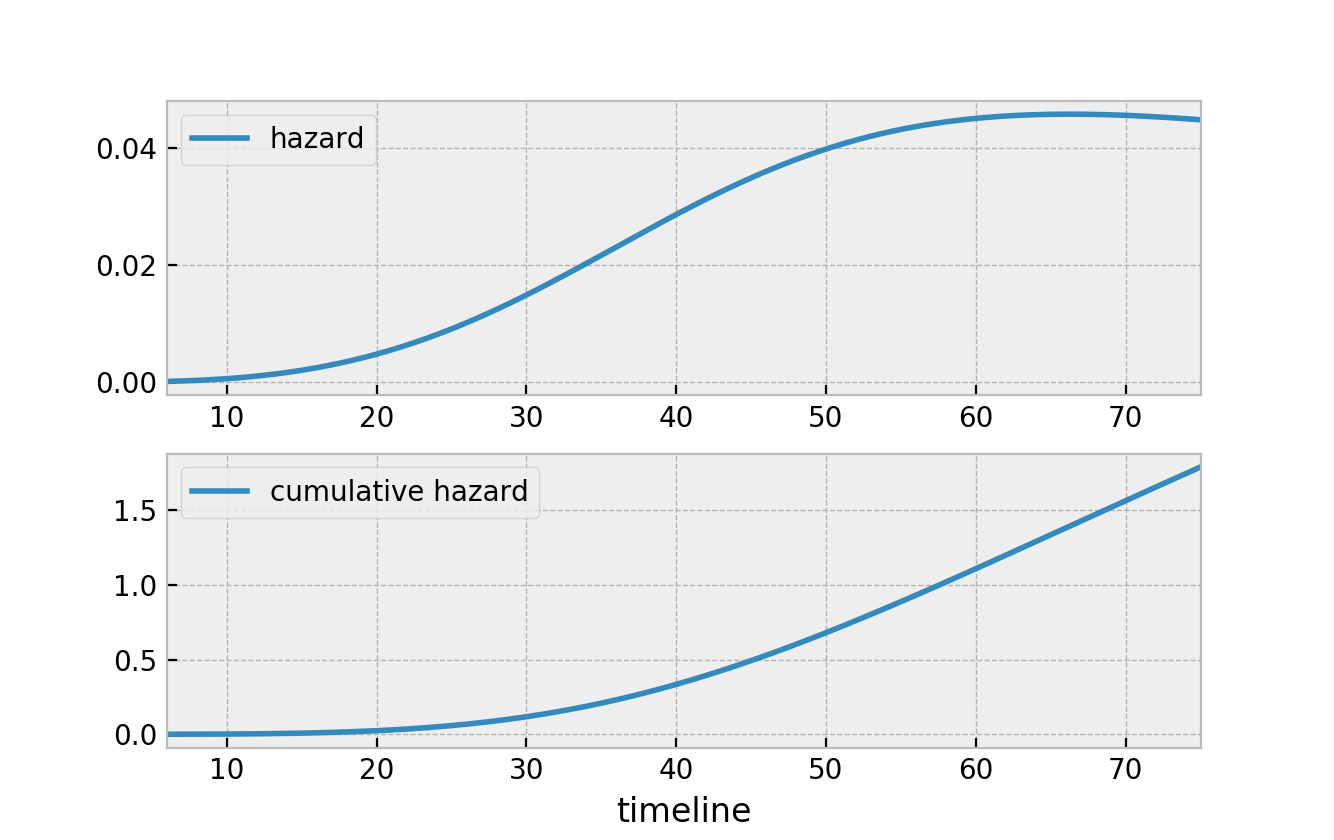

<p style='text-align: justify;'> What I like about the above relationships is that it defines all survival functions. Notice that we can now speak either about the survival function, S(t), the hazard, h(t), or the cumulative hazard function, H(t), and we can convert back and forth quite easily. More detailed information can be found here <a href="https://thomaselove.github.io/432-notes/exploring-time-to-event-survival-data.html">here</a>.

## Loading required libraries
<p style='text-align: justify;'> Once the preliminary study is done and the framework is selected, it is time to think about the required tools to pursue in the implementation of the model. For example, since we will use the survival analysis method for predicting time to the default of the borrowers, the functions such as KaplanMeierFitter, ExponentialFitter, WeibullFitter, CoxPHFitter which are implemented in the lifeline library of Python are imported. </p>

In [3]:
# Import Libraries for array operations
import numpy as np

# Import pndas to deal with dataframes
import pandas as pd

# Import plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import seaborn as sns; sns.set()


# Import machine learning tools from sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score 


# Survival analysis-related libraries
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter, WeibullFitter

#logrank_test
from lifelines.statistics import logrank_test

In [4]:
url = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/Telco-Customer-Churn.csv'
df = pd.read_csv(url, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
df.drop('customerID', axis = 1, inplace = True)

# Multivariate statistical modeling

Kaplan-Meier curves and logrank tests are useful only when the predictor variable is categorical (e.g. treatment A vs treatment B; males vs females). They don’t work easily for quantitative predictors such as gene expression, weight, or age.

An alternative method is the Cox proportional hazards regression analysis, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time. [Referrence](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)

To apply the cox model, we will need to encode the categorical variables, converting to numerical values.

## cleaning data

In [8]:
# Check the number of levels in each categorical variable
object_cols = df.drop(columns=['TotalCharges']).select_dtypes(include='object').columns
unique_levels = pd.DataFrame({'unique_levels': [0]*len(object_cols)}, index=object_cols)

for col in object_cols:
  unique_levels.loc[col, 'unique_levels'] = df[col].nunique()

unique_levels

,unique_levels
gender,2
Partner,2
Dependents,2
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3
OnlineBackup,3
DeviceProtection,3
TechSupport,3


In [9]:
#function to calculate weight of evidence and information value

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)        
        print('Information value of {:30} is {:8.4f}'.format(ivars, round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF
#iv, woe = iv_woe(numerical_features, target = 'good_bad', bins=10)

In [10]:
# function to calculate woe of categorical features

def woe_categorical(df, cat_feature, good_bad_df, label_angel):
    fig , ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = ((15,10)))
    ax2 = ax1.twinx()
    #print([100]*len(df[cat_feature].unique().tolist()))
    #print(df[cat_feature].unique().tolist())
    sns.barplot(ax = ax1, x = df[cat_feature].unique().tolist(), y = [100]*len(df[cat_feature].unique().tolist()),\
                               color = 'blue', alpha = 0.3)
    sns.barplot(ax = ax1, x =  df[cat_feature].unique().tolist(),\
                y = (1- df.groupby(cat_feature)["status"].sum()/df.groupby(cat_feature)["status"].count())*100,\
                color = 'red', alpha = 0.3)
     
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    
    sns.lineplot(ax = ax2, x = np.array(df.iloc[:, 0].apply(str)), y = df['WoE'], markers = 'o', \
                linewidth = 3, markersize = 14 )
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    return df

In [11]:
df['status'] = df['Churn'].apply(lambda x: 1 if(x=='Yes') else 0)

## gender

,gender,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Male,3555,0.261603,0.504756,930.0,2625.0,0.497592,0.507344,-0.019409,NaN,NaN
1,Female,3488,0.269209,0.495244,939.0,2549.0,0.502408,0.492656,0.019602,0.007605,0.039011


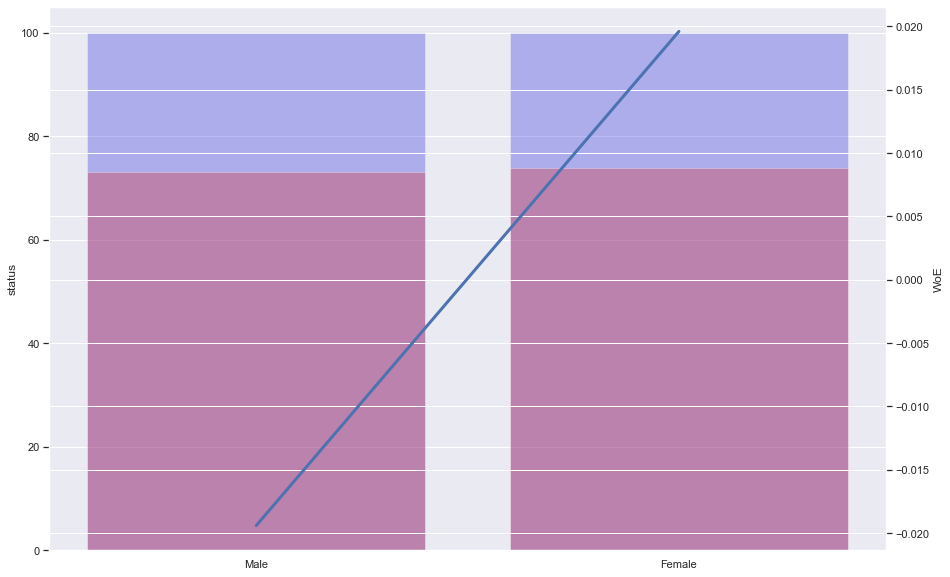

In [12]:
df_grade = woe_categorical(df, 'gender', df['status'] , label_angel = 90)
df_grade

In [13]:
# df['MultipleLines'] = df['MultipleLines'] .replace({'No phone service' : 'No'}, regex=True)

# df['MultipleLines'].unique()


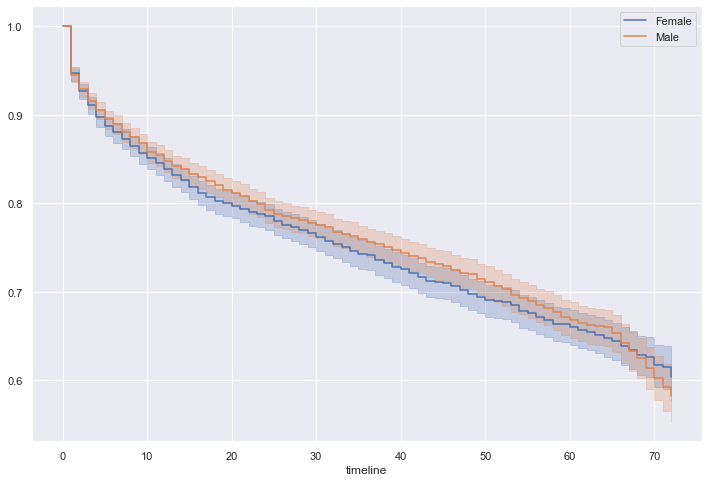

In [14]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['gender', 'status', 'tenure']].groupby('gender'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## Logrank test
<p style='text-align: justify;'> As is shown in above graph, the survival functions of class A, B, and C look pretty distinctive. However, to be precisely estimate how much they are distinctive the quantitative measure should be provided. The Logrank test is one of the most popular method to answer this question. It is the Nullhypothesis checking method and the Null hypothesis is defined as below: </p>
    
Null Hypothesis:

<p style='text-align: justify;'>The survival rates over time between three classes A and B are the same. Then by using the same method the Logrank test between class A and C can bechecked. </p>
    
* $H_0$: The two survival curves are identical (or S1t = S2t) versus 
* $H_1$: The two survival curves are not identical (or S1t ≠ S2t, at any time t) (α=0.05).</p>

<p style='text-align: justify;'>In the below cell we check the distinctivity between each pairs of subclasses. The obtained p-values confirms our first claim which the obtained KM-survival function for three classes A, B and C are distinctive.</p>

In [15]:
# Dividing the dataset into three subdataset to be used in Logrank test.
group1 = df[df['gender']== 'Female']
group2 = df[df['gender']== 'Male']


kmf    = KaplanMeierFitter()

# Class Female and Male
print('Class A and B')
results = logrank_test(group1['tenure'], group2['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group2['status'])
display(results.print_summary())


Class A and B


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.09

None

## Partner

,Partner,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Yes,3402,0.196649,0.483033,669.0,2733.0,0.357945,0.528218,-0.389129,NaN,NaN
1,No,3641,0.329580,0.516967,1200.0,2441.0,0.642055,0.471782,0.308156,0.132931,0.697285


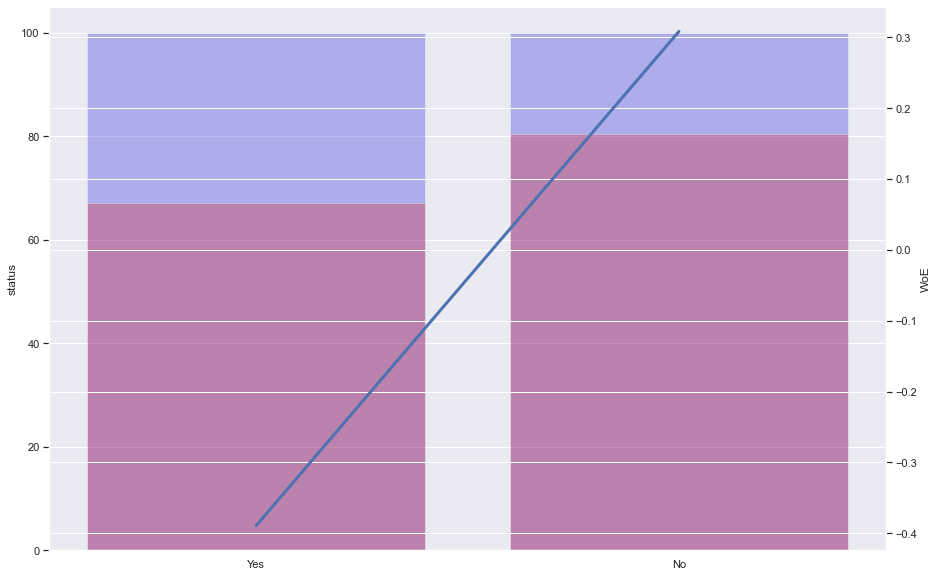

In [16]:
df_grade = woe_categorical(df, 'Partner', df['status'] , label_angel = 90)
df_grade

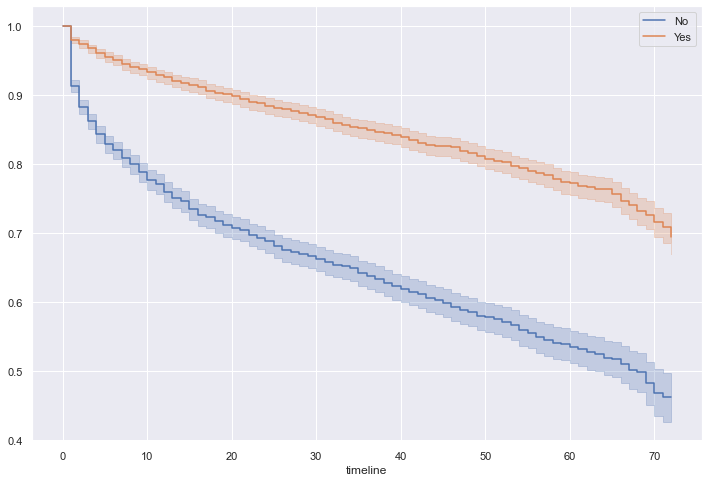

In [17]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['Partner', 'status', 'tenure']].groupby('Partner'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## Dependents

,Dependents,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Yes,2110,0.154502,0.299588,326.0,1784.0,0.174425,0.344801,-0.681473,NaN,NaN
1,No,4933,0.312791,0.700412,1543.0,3390.0,0.825575,0.655199,0.231141,0.158289,0.912615


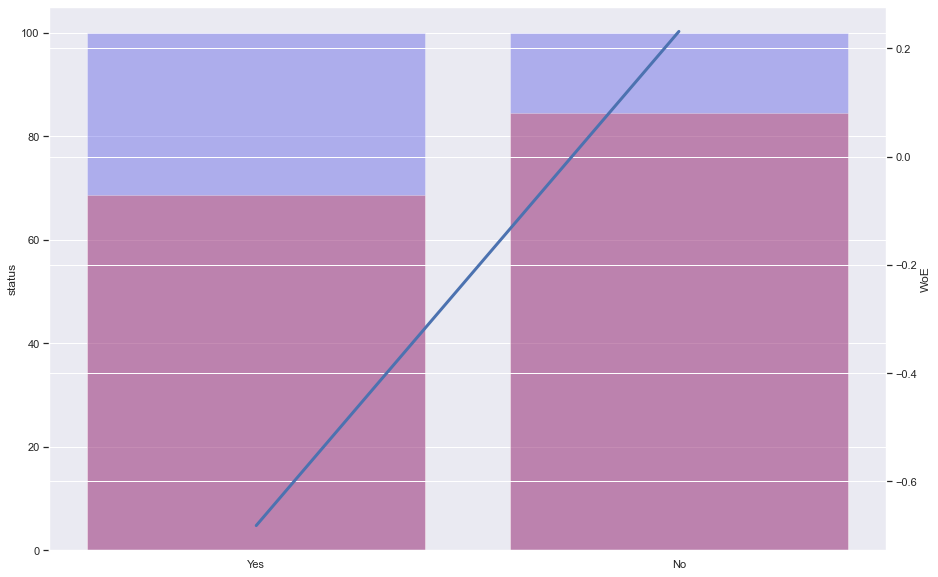

In [18]:
df_grade = woe_categorical(df, 'Dependents', df['status'] , label_angel = 90)
df_grade

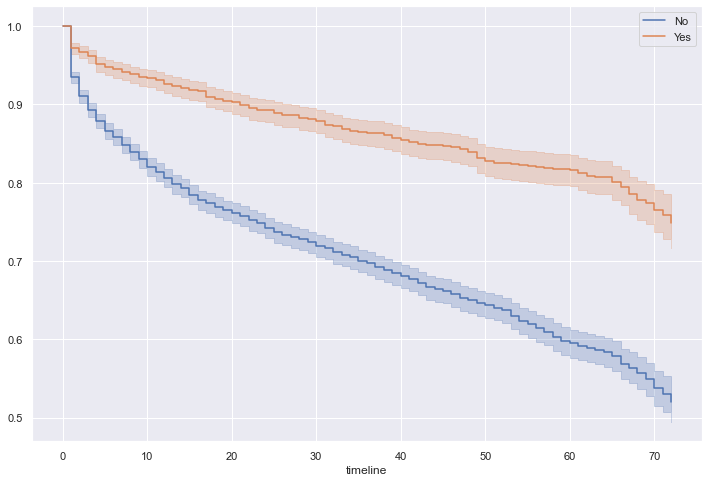

In [19]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['Dependents', 'status', 'tenure']].groupby('Dependents'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## PhoneService

,PhoneService,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No,682,0.249267,0.096834,170.0,512.0,0.090958,0.098956,-0.084284,NaN,NaN
1,Yes,6361,0.267096,0.903166,1699.0,4662.0,0.909042,0.901044,0.008838,0.01783,0.093121


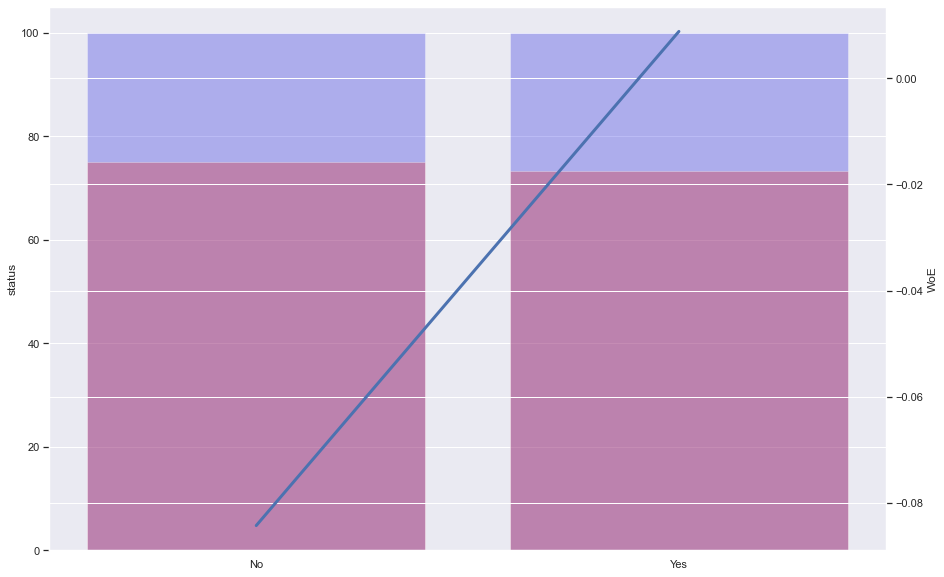

In [20]:
df_grade = woe_categorical(df, 'PhoneService', df['status'] , label_angel = 90)
df_grade

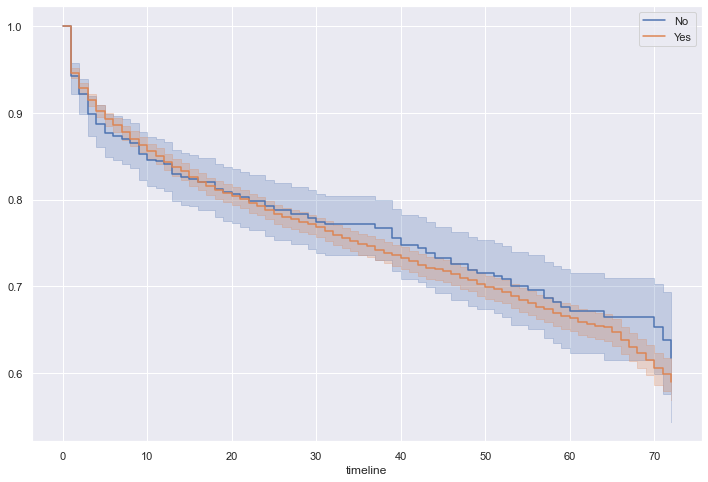

In [21]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['PhoneService', 'status', 'tenure']].groupby('PhoneService'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

In [22]:
# Dividing the dataset into three subdataset to be used in Logrank test.
group1 = df[df['PhoneService']== 'Yes']
group2 = df[df['PhoneService']== 'No']


kmf    = KaplanMeierFitter()

# Class Female and Male
print('Class A and B')
results = logrank_test(group1['tenure'], group2['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group2['status'])
display(results.print_summary())



Class A and B


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.97

None

## MultipleLines

,MultipleLines,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No phone service,682,0.249267,0.096834,170.0,512.0,0.090958,0.098956,-0.084284,NaN,NaN
1,No,3390,0.250442,0.481329,849.0,2541.0,0.454254,0.491109,-0.078011,0.001176,0.006272
2,Yes,2971,0.286099,0.421837,850.0,2121.0,0.454789,0.409934,0.103836,0.035656,0.181847


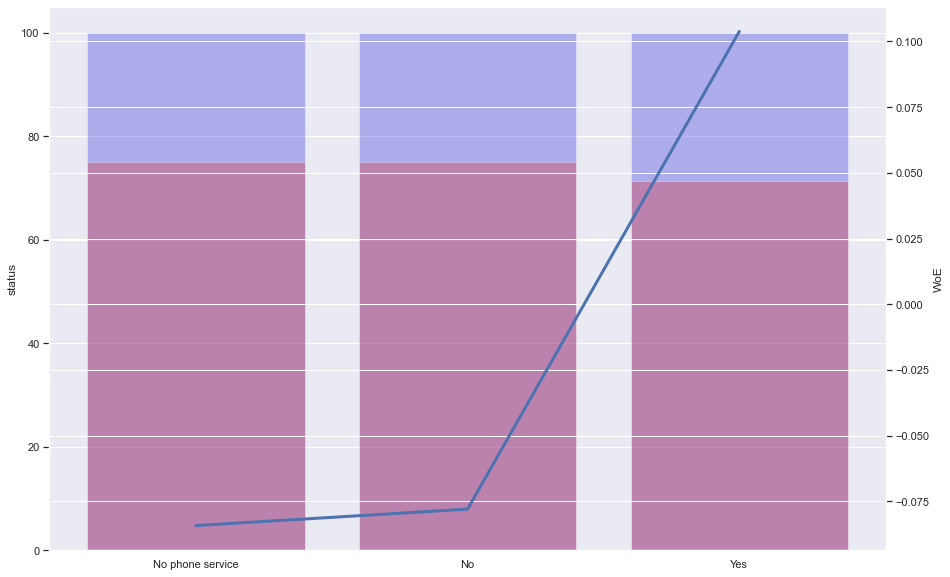

In [23]:
df_grade = woe_categorical(df, 'MultipleLines', df['status'] , label_angel = 90)
df_grade

In [24]:
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service' : 'No'}, regex=True)

,MultipleLines,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No,4072,0.250246,0.578163,1019.0,3053.0,0.545211,0.590066,-0.079060,NaN,NaN
1,Yes,2971,0.286099,0.421837,850.0,2121.0,0.454789,0.409934,0.103836,0.035853,0.182896


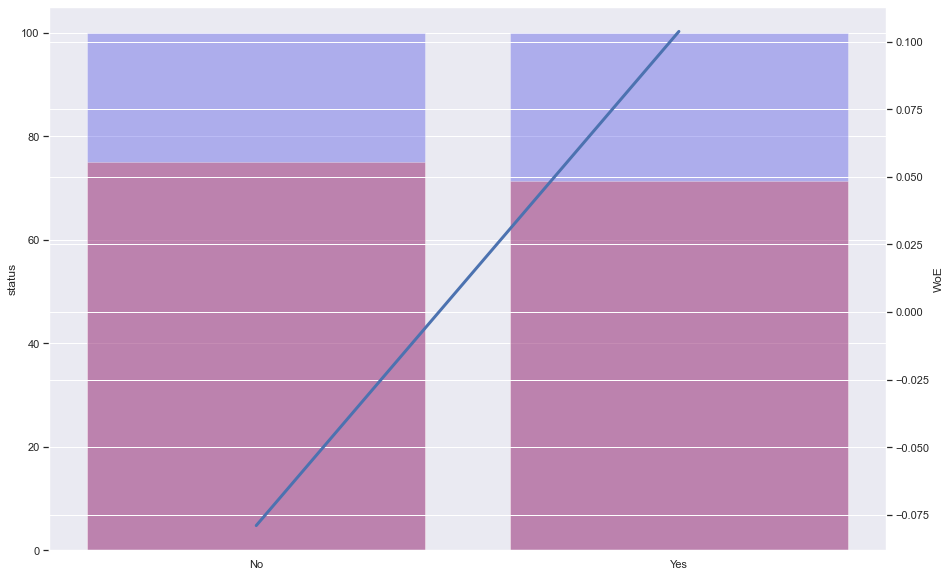

In [25]:
df_grade = woe_categorical(df, 'MultipleLines', df['status'] , label_angel = 90)
df_grade

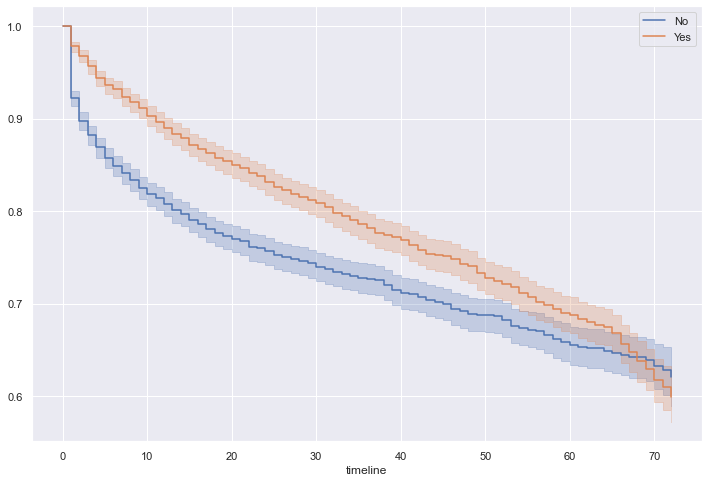

In [26]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['MultipleLines', 'status', 'tenure']].groupby('MultipleLines'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## OnlineSecurity

,OnlineSecurity,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.060460,0.273096,-1.507840,NaN,NaN
1,Yes,2019,0.146112,0.286668,295.0,1724.0,0.157838,0.333204,-0.747185,0.072062,0.760655
2,No,3498,0.417667,0.496663,1461.0,2037.0,0.781701,0.393699,0.685886,0.271555,1.433070


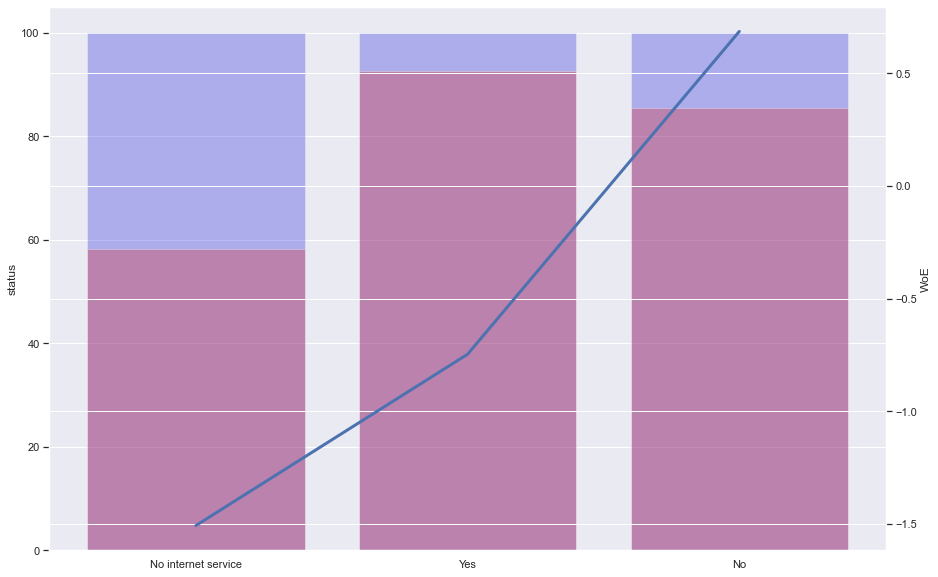

In [27]:
df_grade = woe_categorical(df, 'OnlineSecurity', df['status'] , label_angel = 90)
df_grade

In [28]:
# Dividing the dataset into three subdataset to be used in Logrank test.
group1 = df[df['OnlineSecurity']== 'No internet service']
group2 = df[df['OnlineSecurity']== 'No']
group3 = df[df['OnlineSecurity']== 'Yes']


kmf    = KaplanMeierFitter()

# Class A and B
print('Class A and B')
results = logrank_test(group1['tenure'], group2['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group2['status'])
display(results.print_summary())

# Class A and C
print('Class A and C')
results = logrank_test(group1['tenure'], group3['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group3['status'])
display(results.print_summary())

# Class B and C
print('Class B and C')
results = logrank_test(group2['tenure'], group3['tenure'], \
                     event_observed_A = group2['status'], event_observed_B = group3['status'])
display(results.print_summary())

Class A and B


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         485.98 <0.005    355.35

None

Class A and C


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.06 <0.005     10.15

None

Class B and C


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         660.53 <0.005    481.48

None

## OnlineBackup

,OnlineBackup,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.060460,0.273096,-1.507840,NaN,NaN
1,Yes,2429,0.215315,0.344881,523.0,1906.0,0.279829,0.368380,-0.274938,0.141265,1.232902
2,No,3088,0.399288,0.438450,1233.0,1855.0,0.659711,0.358523,0.609808,0.183973,0.884746


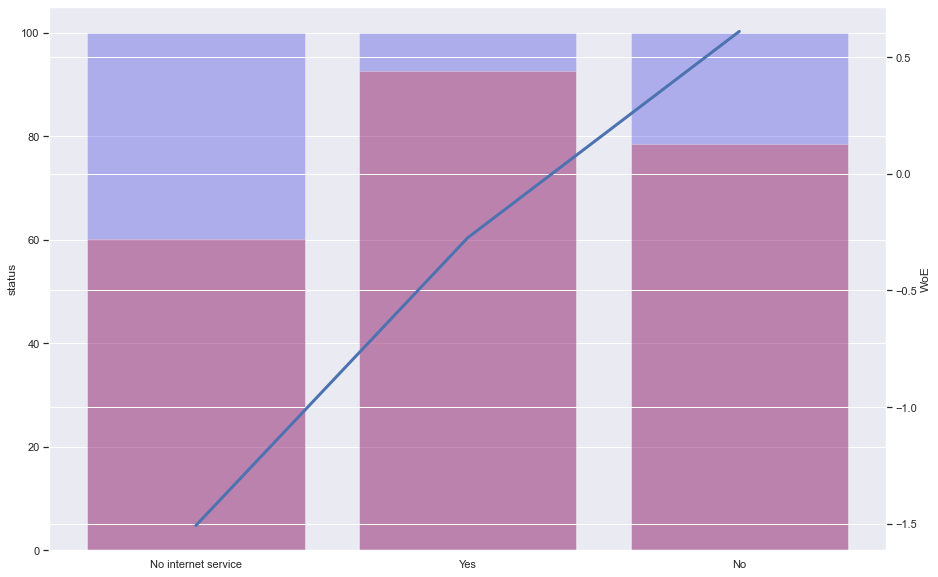

In [29]:
df_grade = woe_categorical(df, 'OnlineBackup', df['status'] , label_angel = 90)
df_grade

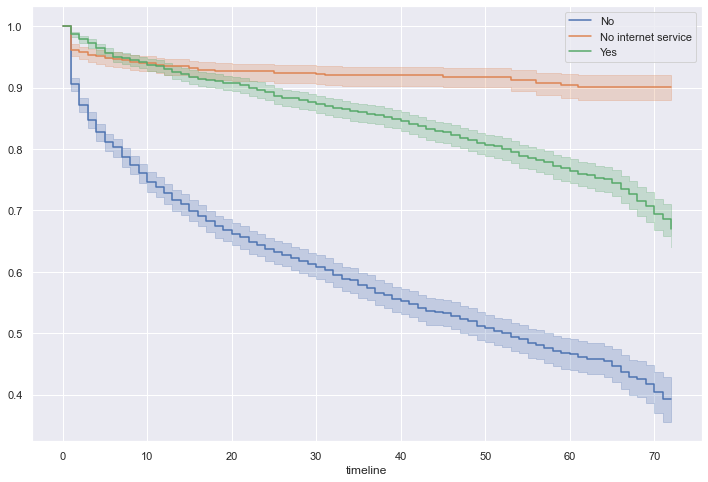

In [30]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['OnlineBackup', 'status', 'tenure']].groupby('OnlineBackup'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## DeviceProtection

,DeviceProtection,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.06046,0.273096,-1.507840,NaN,NaN
1,Yes,2422,0.225021,0.343888,545.0,1877.0,0.29160,0.362775,-0.218402,0.150971,1.289438
2,No,3095,0.391276,0.439443,1211.0,1884.0,0.64794,0.364128,0.576292,0.166256,0.794694


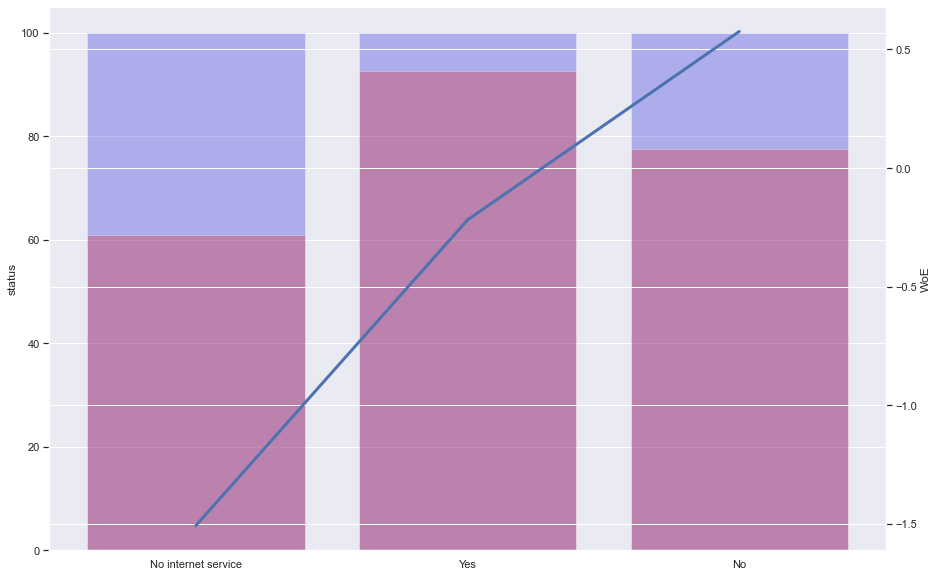

In [31]:
df_grade = woe_categorical(df, 'DeviceProtection', df['status'] , label_angel = 90)
df_grade

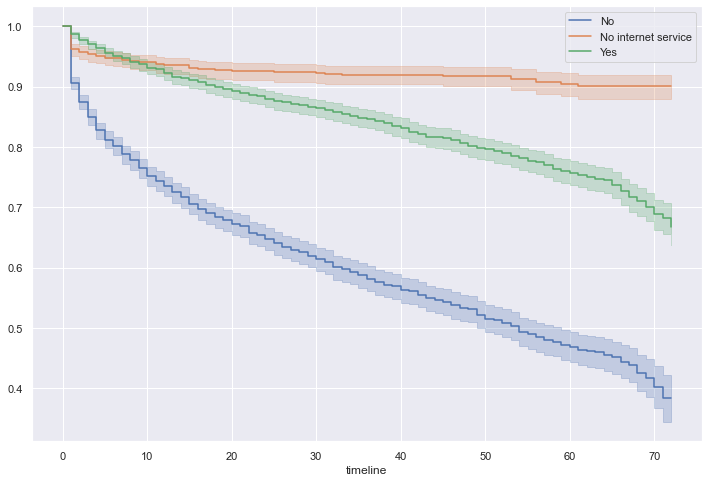

In [32]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['DeviceProtection', 'status', 'tenure']].groupby('DeviceProtection'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## TechSupport

,TechSupport,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.060460,0.273096,-1.507840,NaN,NaN
1,Yes,2044,0.151663,0.290217,310.0,1734.0,0.165864,0.335137,-0.703371,0.077614,0.804469
2,No,3473,0.416355,0.493114,1446.0,2027.0,0.773676,0.391767,0.680487,0.264691,1.383858


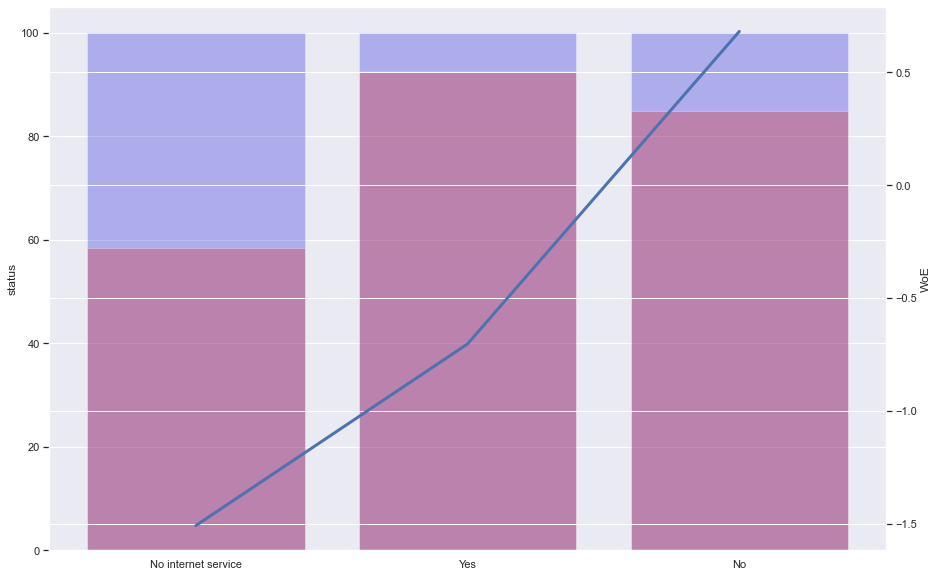

In [33]:
df_grade = woe_categorical(df, 'TechSupport', df['status'] , label_angel = 90)
df_grade

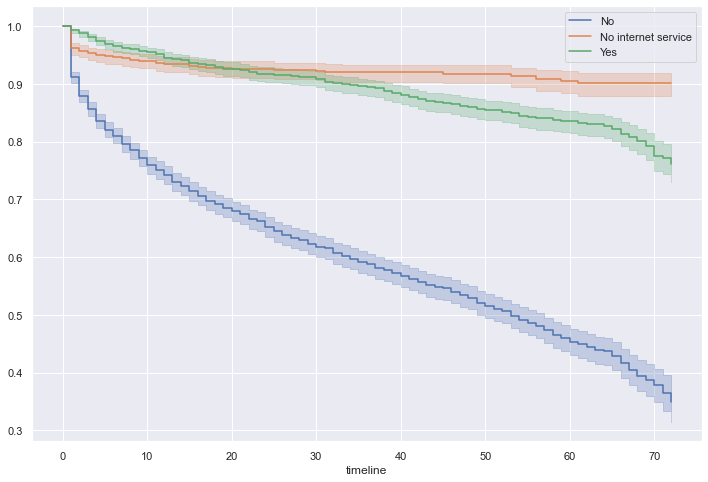

In [34]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['TechSupport', 'status', 'tenure']].groupby('TechSupport'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## StreamingTV

,StreamingTV,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.060460,0.273096,-1.507840,NaN,NaN
1,Yes,2707,0.300702,0.384353,814.0,1893.0,0.435527,0.365868,0.174285,0.226652,1.682125
2,No,2810,0.335231,0.398978,942.0,1868.0,0.504013,0.361036,0.333624,0.034529,0.159339


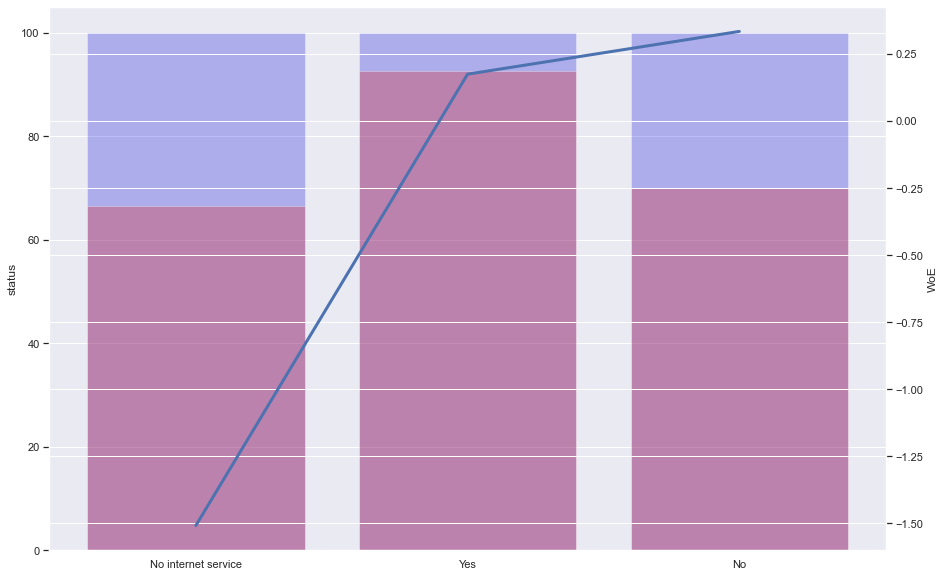

In [35]:
df_grade = woe_categorical(df, 'StreamingTV', df['status'] , label_angel = 90)
df_grade

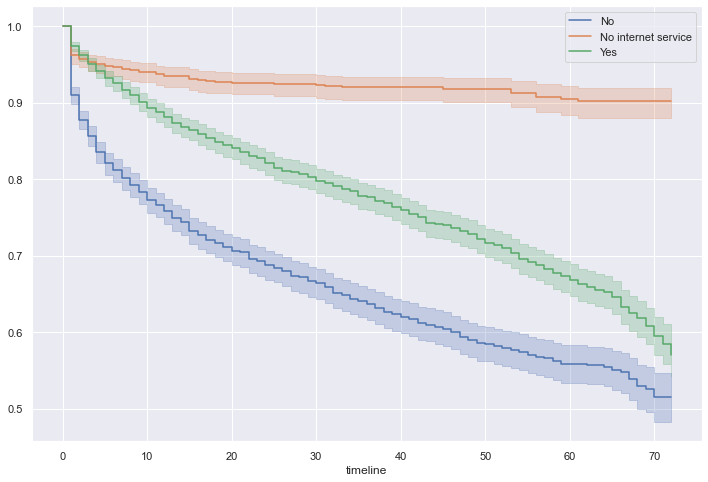

In [36]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['StreamingTV', 'status', 'tenure']].groupby('StreamingTV'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

In [37]:
# Dividing the dataset into three subdataset to be used in Logrank test.
group1 = df[df['StreamingTV']== 'No internet service']
group2 = df[df['StreamingTV']== 'No']
group3 = df[df['StreamingTV']== 'Yes']


kmf    = KaplanMeierFitter()

# Class A and B
print('Class A and B')
results = logrank_test(group1['tenure'], group2['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group2['status'])
display(results.print_summary())

# Class A and C
print('Class A and C')
results = logrank_test(group1['tenure'], group3['tenure'], \
                     event_observed_A = group1['status'], event_observed_B = group3['status'])
display(results.print_summary())

# Class B and C
print('Class B and C')
results = logrank_test(group2['tenure'], group3['tenure'], \
                     event_observed_A = group2['status'], event_observed_B = group3['status'])
display(results.print_summary())

Class A and B


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         336.02 <0.005    246.92

None

Class A and C


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         148.31 <0.005    110.92

None

Class B and C


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         103.85 <0.005     78.60

None

## StreamingMovies

,StreamingMovies,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No internet service,1526,0.074050,0.216669,113.0,1413.0,0.060460,0.273096,-1.507840,NaN,NaN
1,Yes,2732,0.299414,0.387903,818.0,1914.0,0.437667,0.369927,0.168154,0.225365,1.675994
2,No,2785,0.336804,0.395428,938.0,1847.0,0.501873,0.356977,0.340675,0.037390,0.172520


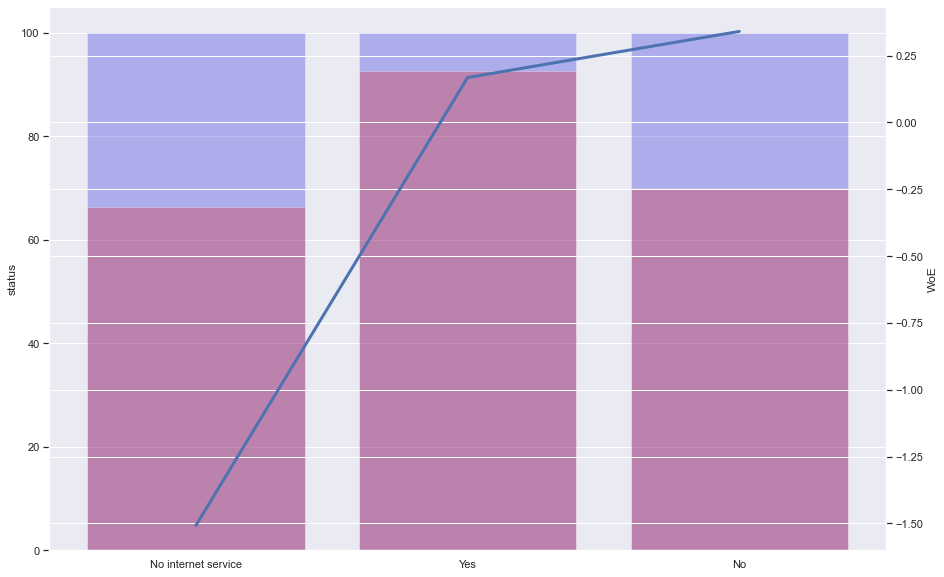

In [38]:
df_grade = woe_categorical(df, 'StreamingMovies', df['status'] , label_angel = 90)
df_grade

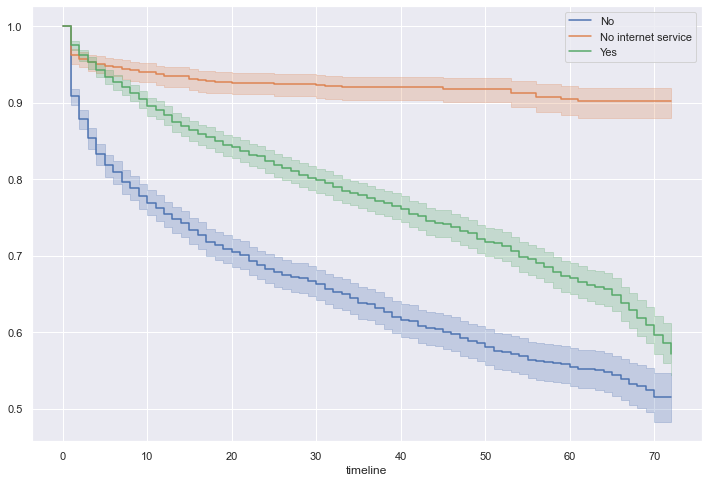

In [39]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['StreamingMovies', 'status', 'tenure']].groupby('StreamingMovies'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## Contract

,Contract,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Two year,1695,0.028319,0.240664,48.0,1647.0,0.025682,0.318322,-2.517267,NaN,NaN
1,One year,1473,0.112695,0.209144,166.0,1307.0,0.088818,0.252609,-1.045259,0.084377,1.472008
2,Month-to-month,3875,0.427097,0.550192,1655.0,2220.0,0.885500,0.429068,0.724536,0.314402,1.769796


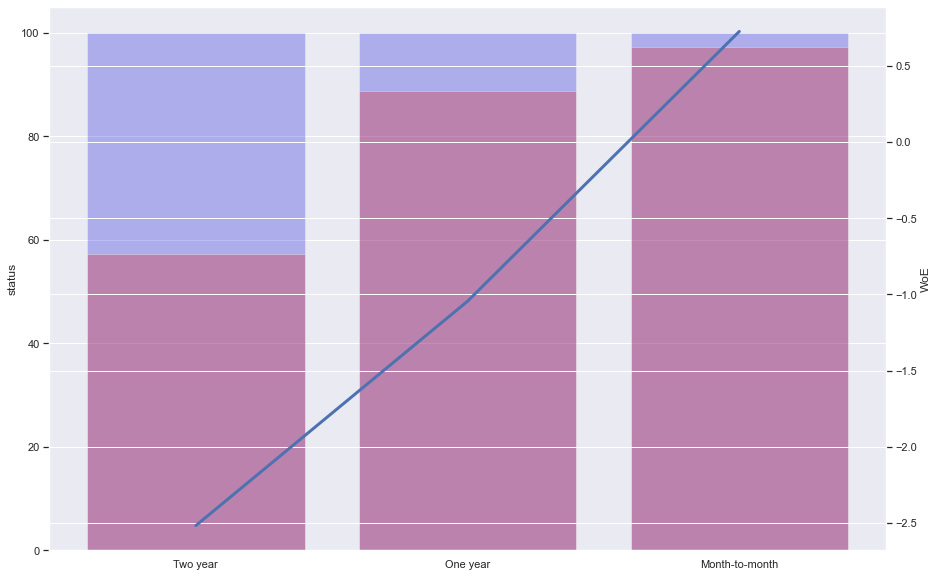

In [40]:
df_grade = woe_categorical(df, 'Contract', df['status'] , label_angel = 90)
df_grade

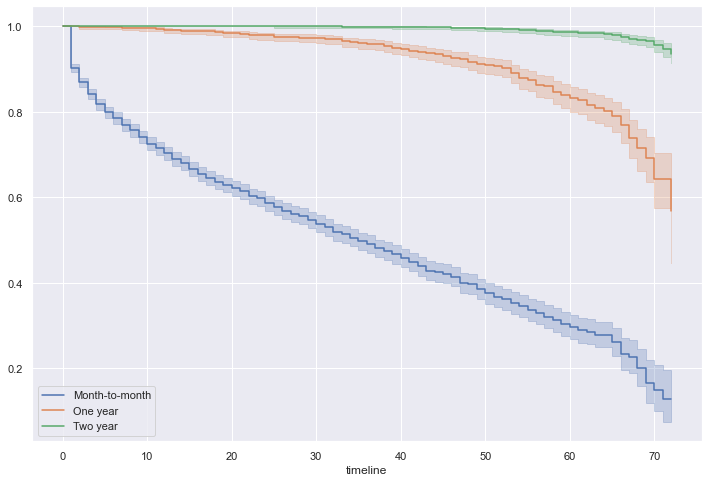

In [41]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['Contract', 'status', 'tenure']].groupby('Contract'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## PaperlessBilling

,PaperlessBilling,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,No,2872,0.163301,0.407781,469.0,2403.0,0.250936,0.464438,-0.615628,NaN,NaN
1,Yes,4171,0.335651,0.592219,1400.0,2771.0,0.749064,0.535562,0.335507,0.17235,0.951134


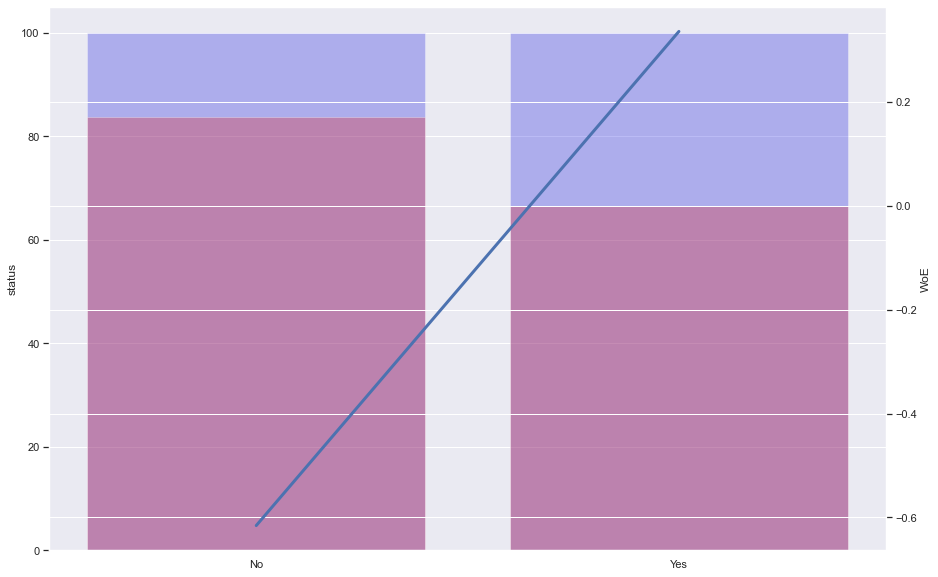

In [42]:
df_grade = woe_categorical(df, 'PaperlessBilling', df['status'] , label_angel = 90)
df_grade

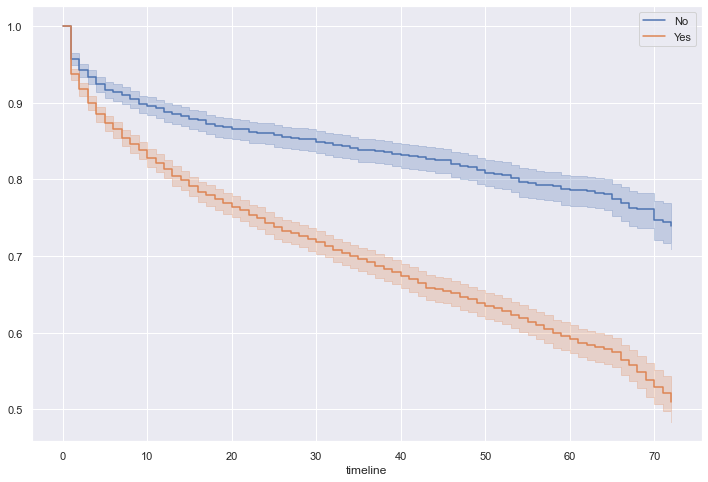

In [43]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['PaperlessBilling', 'status', 'tenure']].groupby('PaperlessBilling'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

## PaymentMethod

,PaymentMethod,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Credit card (automatic),1522,0.152431,0.216101,232.0,1290.0,0.124131,0.249324,-0.697418,NaN,NaN
1,Bank transfer (automatic),1544,0.167098,0.219225,258.0,1286.0,0.138042,0.248550,-0.588090,0.014667,0.109328
2,Mailed check,1612,0.191067,0.228880,308.0,1304.0,0.164794,0.252029,-0.424849,0.023969,0.163240
3,Electronic check,2365,0.452854,0.335794,1071.0,1294.0,0.573034,0.250097,0.829097,0.261787,1.253947


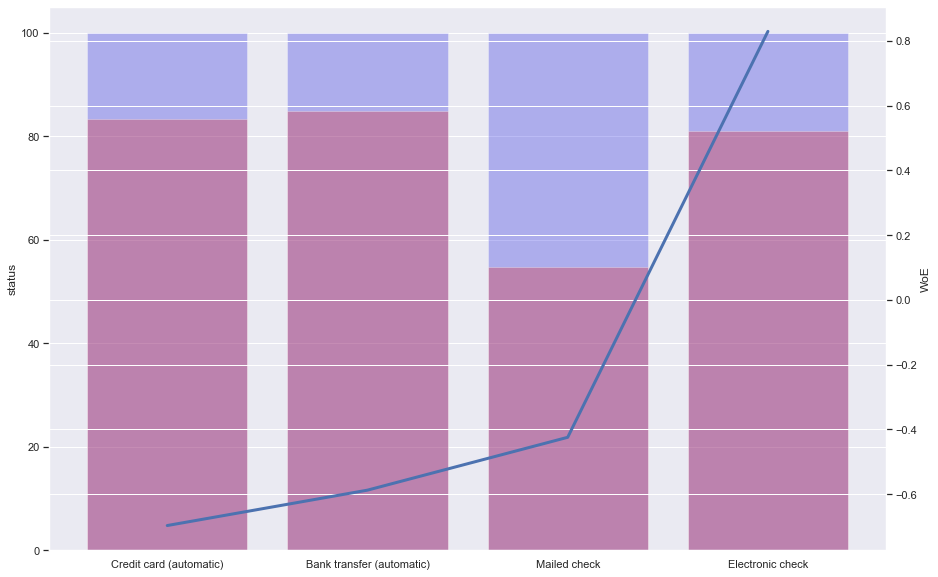

In [44]:
df_grade = woe_categorical(df, 'PaymentMethod', df['status'] , label_angel = 90)
df_grade

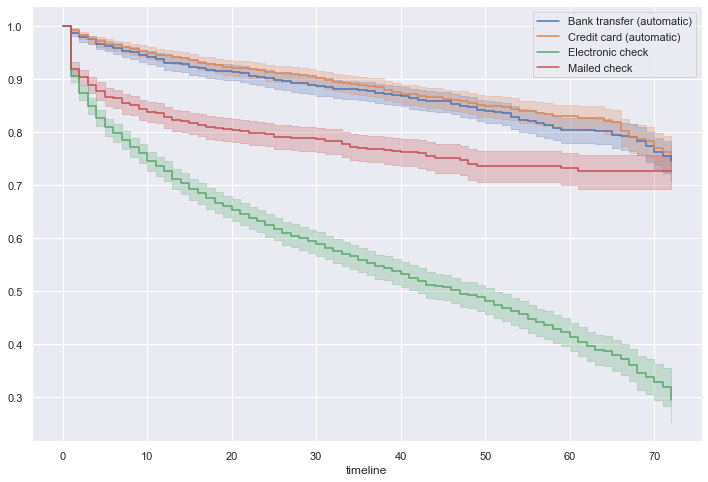

In [45]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['PaymentMethod', 'status', 'tenure']].groupby('PaymentMethod'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

In [46]:
df['PaymentMethod'] = df['PaymentMethod'].replace({'Bank transfer (automatic)':'Credit card (automatic)'}) 

,PaymentMethod,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,Credit card (automatic),3066,0.159817,0.435326,490.0,2576.0,0.262172,0.497874,-0.641345,NaN,NaN
1,Mailed check,1612,0.191067,0.228880,308.0,1304.0,0.164794,0.252029,-0.424849,0.031250,0.216496
2,Electronic check,2365,0.452854,0.335794,1071.0,1294.0,0.573034,0.250097,0.829097,0.261787,1.253947


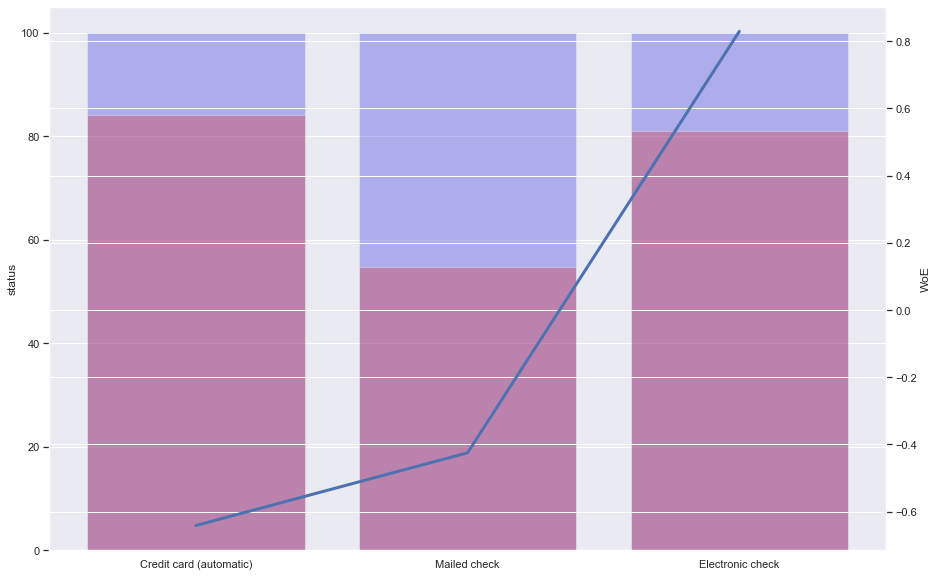

In [47]:
df_grade = woe_categorical(df, 'PaymentMethod', df['status'] , label_angel = 90)
df_grade

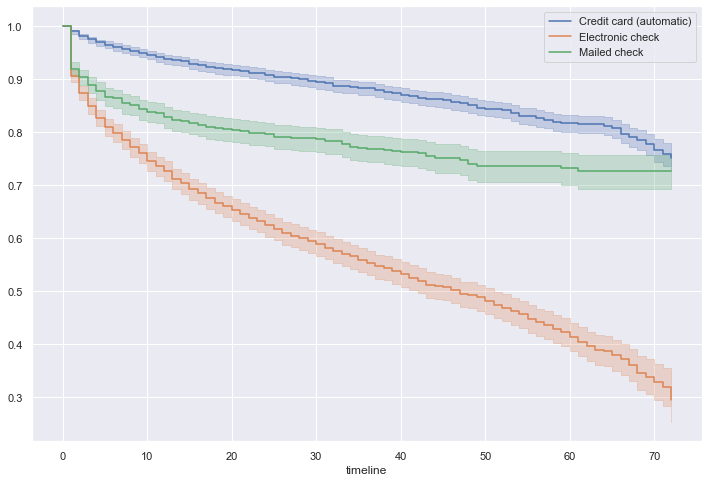

In [48]:
# Calculate Kaplan-Mierr survival function to check if they look distinctive
fig = plt.figure(figsize=(12, 8))
ax  = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['PaymentMethod', 'status', 'tenure']].groupby('PaymentMethod'):
    kmf.fit(df_['tenure'], df_['status'], label = name)
    ax = kmf.plot(ax = ax, ci_show = True)

Note, when I start to apply coxphfitter function, it failed due to non-convergence. The reason is the suspicion is high collinearity. According to [Cam Davidson Pilon](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb), some of the features have heirarchical natures. Such as, if one doesn't have internet service, their online security is not applicable, because `no internet service'. The best way is to treat the hierachical nature by stratifying on the different services a user may have. Here I will stratifying users based on if they have internet service on not. 
Besides, we also need to revise the 'No internet service' to no.

In [49]:
object_cols = df.drop(columns=['TotalCharges', 'InternetService', 'gender', 'PhoneService']).select_dtypes(include='object').columns
fix_ = df[object_cols].applymap(lambda x: "No" if str(x).startswith("No ") else x)
ndf = fix_.join(df[['tenure', 'MonthlyCharges', 'InternetService', 'SeniorCitizen']])

# get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(ndf, prefix=object_cols, columns=object_cols, drop_first=True)
df_enc.head()

,tenure,MonthlyCharges,InternetService,SeniorCitizen,Partner_Yes,Dependents_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,DSL,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0
1,34,56.95,DSL,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,2,53.85,DSL,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1
3,45,42.30,DSL,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0
4,2,70.70,Fiber optic,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


## build model

In [50]:
#pip install lifelines

In [51]:
cph_train, cph_test = train_test_split(df_enc, test_size=0.2) 

In [52]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(df_enc, 'tenure', 'Churn_Yes', strata=['InternetService'], show_progress=True)

Iteration 1: norm_delta = 0.97550, step_size = 0.9000, log_lik = -13939.15726, newton_decrement = 1215.29006, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.47441, step_size = 0.9000, log_lik = -12650.39754, newton_decrement = 134.57686, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.29753, step_size = 0.9000, log_lik = -12501.37539, newton_decrement = 21.79627, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.10677, step_size = 1.0000, log_lik = -12476.62232, newton_decrement = 1.48015, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.01118, step_size = 1.0000, log_lik = -12475.05585, newton_decrement = 0.01331, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00011, step_size = 1.0000, log_lik = -12475.04246, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, log_lik = -12475.04246, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 7 iterations.


In [53]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
                   strata = ['InternetService']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12475.04
         time fit was run = 2021-12-28 19:13:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
SeniorCitizen                   -0.08       0.93       0.06            -0.19             0.04                 0.83                 1.04
Partner_Yes                     -0.52       0.59       0.06            -0.63            -0.41                 0.53                 0.66
Dependents_Yes                  -0.05       0.95       0.07            -0.19             0.08                 0.83                 1.09
MultipleLines_Yes               -0.49       0.62       0.06            -0.61            -0.36                 0.54                 0.70
OnlineSecurity_Yes              -0.68       0.51       0.07            -0.82            -0.54                 0.44                 0.59
OnlineBackup_Yes                -0.69       0.50       0.06            -0.81            -0.57                 0.45                 0.56
DeviceProtection_Yes            -0.35       0.70       0.06            -0.47            -0.24                 0.63                 0.79
TechSupport_Yes                 -0.44       0.65       0.07            -0.58            -0.30                 0.56                 0.74
StreamingTV_Yes                 -0.08       0.93       0.07            -0.22             0.06                 0.81                 1.07
StreamingMovies_Yes             -0.18       0.84       0.07            -0.32            -0.04                 0.73                 0.96
Contract_One year               -1.55       0.21       0.09            -1.72            -1.38                 0.18                 0.25
Contract_Two year               -2.98       0.05       0.17            -3.31            -2.65                 0.04                 0.07
PaperlessBilling_Yes             0.19       1.21       0.06             0.08             0.30                 1.08                 1.35
PaymentMethod_Electronic check   0.64       1.89       0.06             0.53             0.75                 1.69                 2.11
PaymentMethod_Mailed check       0.56       1.75       0.08             0.41             0.71                 1.51                 2.04

                                    z      p   -log2(p)
covariate                                              
MonthlyCharges                   0.51   0.61       0.71
SeniorCitizen                   -1.33   0.18       2.44
Partner_Yes                     -9.46 <0.005      68.20
Dependents_Yes                  -0.74   0.46       1.12
MultipleLines_Yes               -7.75 <0.005      46.60
OnlineSecurity_Yes              -9.37 <0.005      66.97
OnlineBackup_Yes               -11.59 <0.005     100.75
DeviceProtection_Yes            -5.91 <0.005      28.11
TechSupport_Yes                 -6.15 <0.005      30.26
StreamingTV_Yes                 -1.07   0.28       1.82
StreamingMovies_Yes             -2.46   0.01       6.18
Contract_One year              -17.60 <0.005     227.81
Contract_Two year              -17.77 <0.005     232.23
PaperlessBilling_Yes             3.34 <0.005      10.23
PaymentMethod_Electronic check  11.21 <0.005      94.41
PaymentMethod_Mailed check       7.22 <0.005      40.82
---
Concordance = 0.85
Partial AIC = 24982.08
log-likelihood ratio test = 2928.23 on 16 df
-log2(p) of ll-ratio test = inf

As you can see here, the `print_summary` output did not show the natural p value nor concordance value like the [documented example](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb). I've raised this question on stackoverflow. But we can get the concordance index as below. Since -log2(p) is infinite, the p should be very small.

In [54]:
cph.concordance_index_

0.8454952221201367

## Interpretation

In [55]:
cph.summary.sort_values(by='p', ascending=True).round(4)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Contract_Two year,-2.9789,0.0509,0.1676,-3.3074,-2.6503,0.0366,0.0706,-17.7688,0.0000,232.2327
Contract_One year,-1.5496,0.2123,0.0881,-1.7222,-1.3770,0.1787,0.2523,-17.5959,0.0000,227.8090
OnlineBackup_Yes,-0.6919,0.5006,0.0597,-0.8089,-0.5749,0.4453,0.5628,-11.5889,0.0000,100.7501
PaymentMethod_Electronic check,0.6370,1.8909,0.0568,0.5256,0.7485,1.6915,2.1138,11.2065,0.0000,94.4135
Partner_Yes,-0.5221,0.5933,0.0552,-0.6302,-0.4140,0.5325,0.6610,-9.4645,0.0000,68.2006
OnlineSecurity_Yes,-0.6767,0.5083,0.0722,-0.8182,-0.5352,0.4412,0.5855,-9.3749,0.0000,66.9690
MultipleLines_Yes,-0.4853,0.6155,0.0626,-0.6081,-0.3626,0.5444,0.6959,-7.7473,0.0000,46.5978
PaymentMethod_Mailed check,0.5620,1.7542,0.0778,0.4095,0.7146,1.5061,2.0433,7.2214,0.0000,40.8219
TechSupport_Yes,-0.4371,0.6459,0.0711,-0.5764,-0.2978,0.5619,0.7424,-6.1499,0.0000,30.2644


There are 7k+ customers in this dataset, 1869 of them have churned.

What we see here is the coefficients as the effects to customer churn risk. The negative indicates customer with that feature is less likely to churn, while the positive coefficients indicate the opposite.

Here, there are four features that have significant impact (p value extremely small) to lower churn risk:

* contract two year
* contract one year
* online backup
* online security

The concordance of this model is 0.86. I found this [article](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7) really helpful to understand what concordance means. In this case, our prediction is not bad at all.


In [56]:
selected_features_1 = ['Contract', 'Partner', 'MultipleLines', 'PaperlessBilling', \
                     'tenure',  'InternetService', 'Churn']


selected_features_2 = ['Contract', 'Partner', 'MultipleLines',  'PaperlessBilling', \
                      'Churn']

fix = df[selected_features_1]
fix.head()

,Contract,Partner,MultipleLines,PaperlessBilling,tenure,InternetService,Churn
0,Month-to-month,Yes,No,Yes,1,DSL,No
1,One year,No,No,No,34,DSL,No
2,Month-to-month,No,No,Yes,2,DSL,Yes
3,One year,No,No,No,45,DSL,No
4,Month-to-month,No,No,Yes,2,Fiber optic,Yes


In [57]:
# # get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(fix, prefix = selected_features_2, columns = selected_features_2, drop_first = True)
df_enc.head()

,tenure,InternetService,Contract_One year,Contract_Two year,Partner_Yes,MultipleLines_Yes,PaperlessBilling_Yes,Churn_Yes
0,1,DSL,0,0,1,0,1,0
1,34,DSL,1,0,0,0,0,0
2,2,DSL,0,0,0,0,1,1
3,45,DSL,1,0,0,0,0,0
4,2,Fiber optic,0,0,0,0,1,1


In [58]:
cph = CoxPHFitter().fit(df_enc, 'tenure', 'Churn_Yes', strata=['InternetService'], show_progress=True)

Iteration 1: norm_delta = 1.18463, step_size = 0.9000, log_lik = -13939.15726, newton_decrement = 995.29871, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.50413, step_size = 0.9000, log_lik = -12897.42894, newton_decrement = 95.33907, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.29223, step_size = 0.9000, log_lik = -12790.93917, newton_decrement = 17.17749, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.09499, step_size = 1.0000, log_lik = -12771.39032, newton_decrement = 1.13460, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00875, step_size = 1.0000, log_lik = -12770.19597, newton_decrement = 0.00816, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00007, step_size = 1.0000, log_lik = -12770.18776, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, log_lik = -12770.18776, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 7 iterations.


In [59]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
                   strata = ['InternetService']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12770.19
         time fit was run = 2021-12-28 19:13:16 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Contract_One year     -1.99       0.14       0.08            -2.16            -1.83                 0.12                 0.16
Contract_Two year     -3.74       0.02       0.16            -4.06            -3.43                 0.02                 0.03
Partner_Yes           -0.62       0.54       0.05            -0.72            -0.52                 0.49                 0.60
MultipleLines_Yes     -0.56       0.57       0.05            -0.66            -0.45                 0.52                 0.64
PaperlessBilling_Yes   0.16       1.17       0.06             0.05             0.27                 1.05                 1.31

                          z      p   -log2(p)
covariate                                    
Contract_One year    -23.49 <0.005     403.00
Contract_Two year    -23.04 <0.005     387.63
Partner_Yes          -12.33 <0.005     113.59
MultipleLines_Yes    -10.57 <0.005      84.39
PaperlessBilling_Yes   2.84 <0.005       7.79
---
Concordance = 0.80
Partial AIC = 25550.38
log-likelihood ratio test = 2337.94 on 5 df
-log2(p) of ll-ratio test = inf

In [60]:
#cph.check_assumptions(df_enc)

It seems the features with only two level fail the non-proportional test. The suggestion here is to specify a strata. It's a good way if we want to improve our model further. Here I will leave it as it is.

Below is the visualisation plot of the coefficients shown above.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

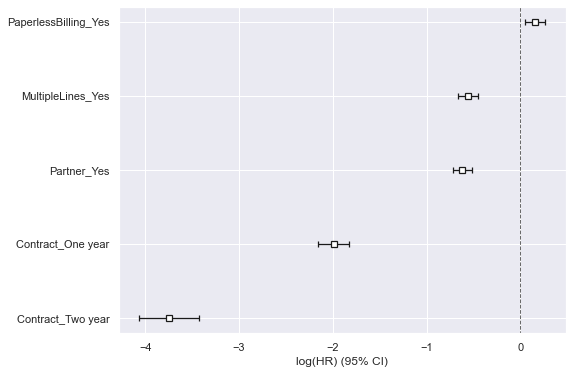

In [61]:
plt.figure(figsize=(8, 6))
cph.plot()

In [62]:
censored_subjects = df_enc.loc[df_enc['Churn_Yes'] == 0]

In [63]:
unconditioned_sf = cph.predict_survival_function(censored_subjects)


In [64]:
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df_enc.loc[c.name, 'tenure']]).clip(upper = 1))

In [65]:
# subject = 12 
# unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned") 
# conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>58$")
# plt.legend()

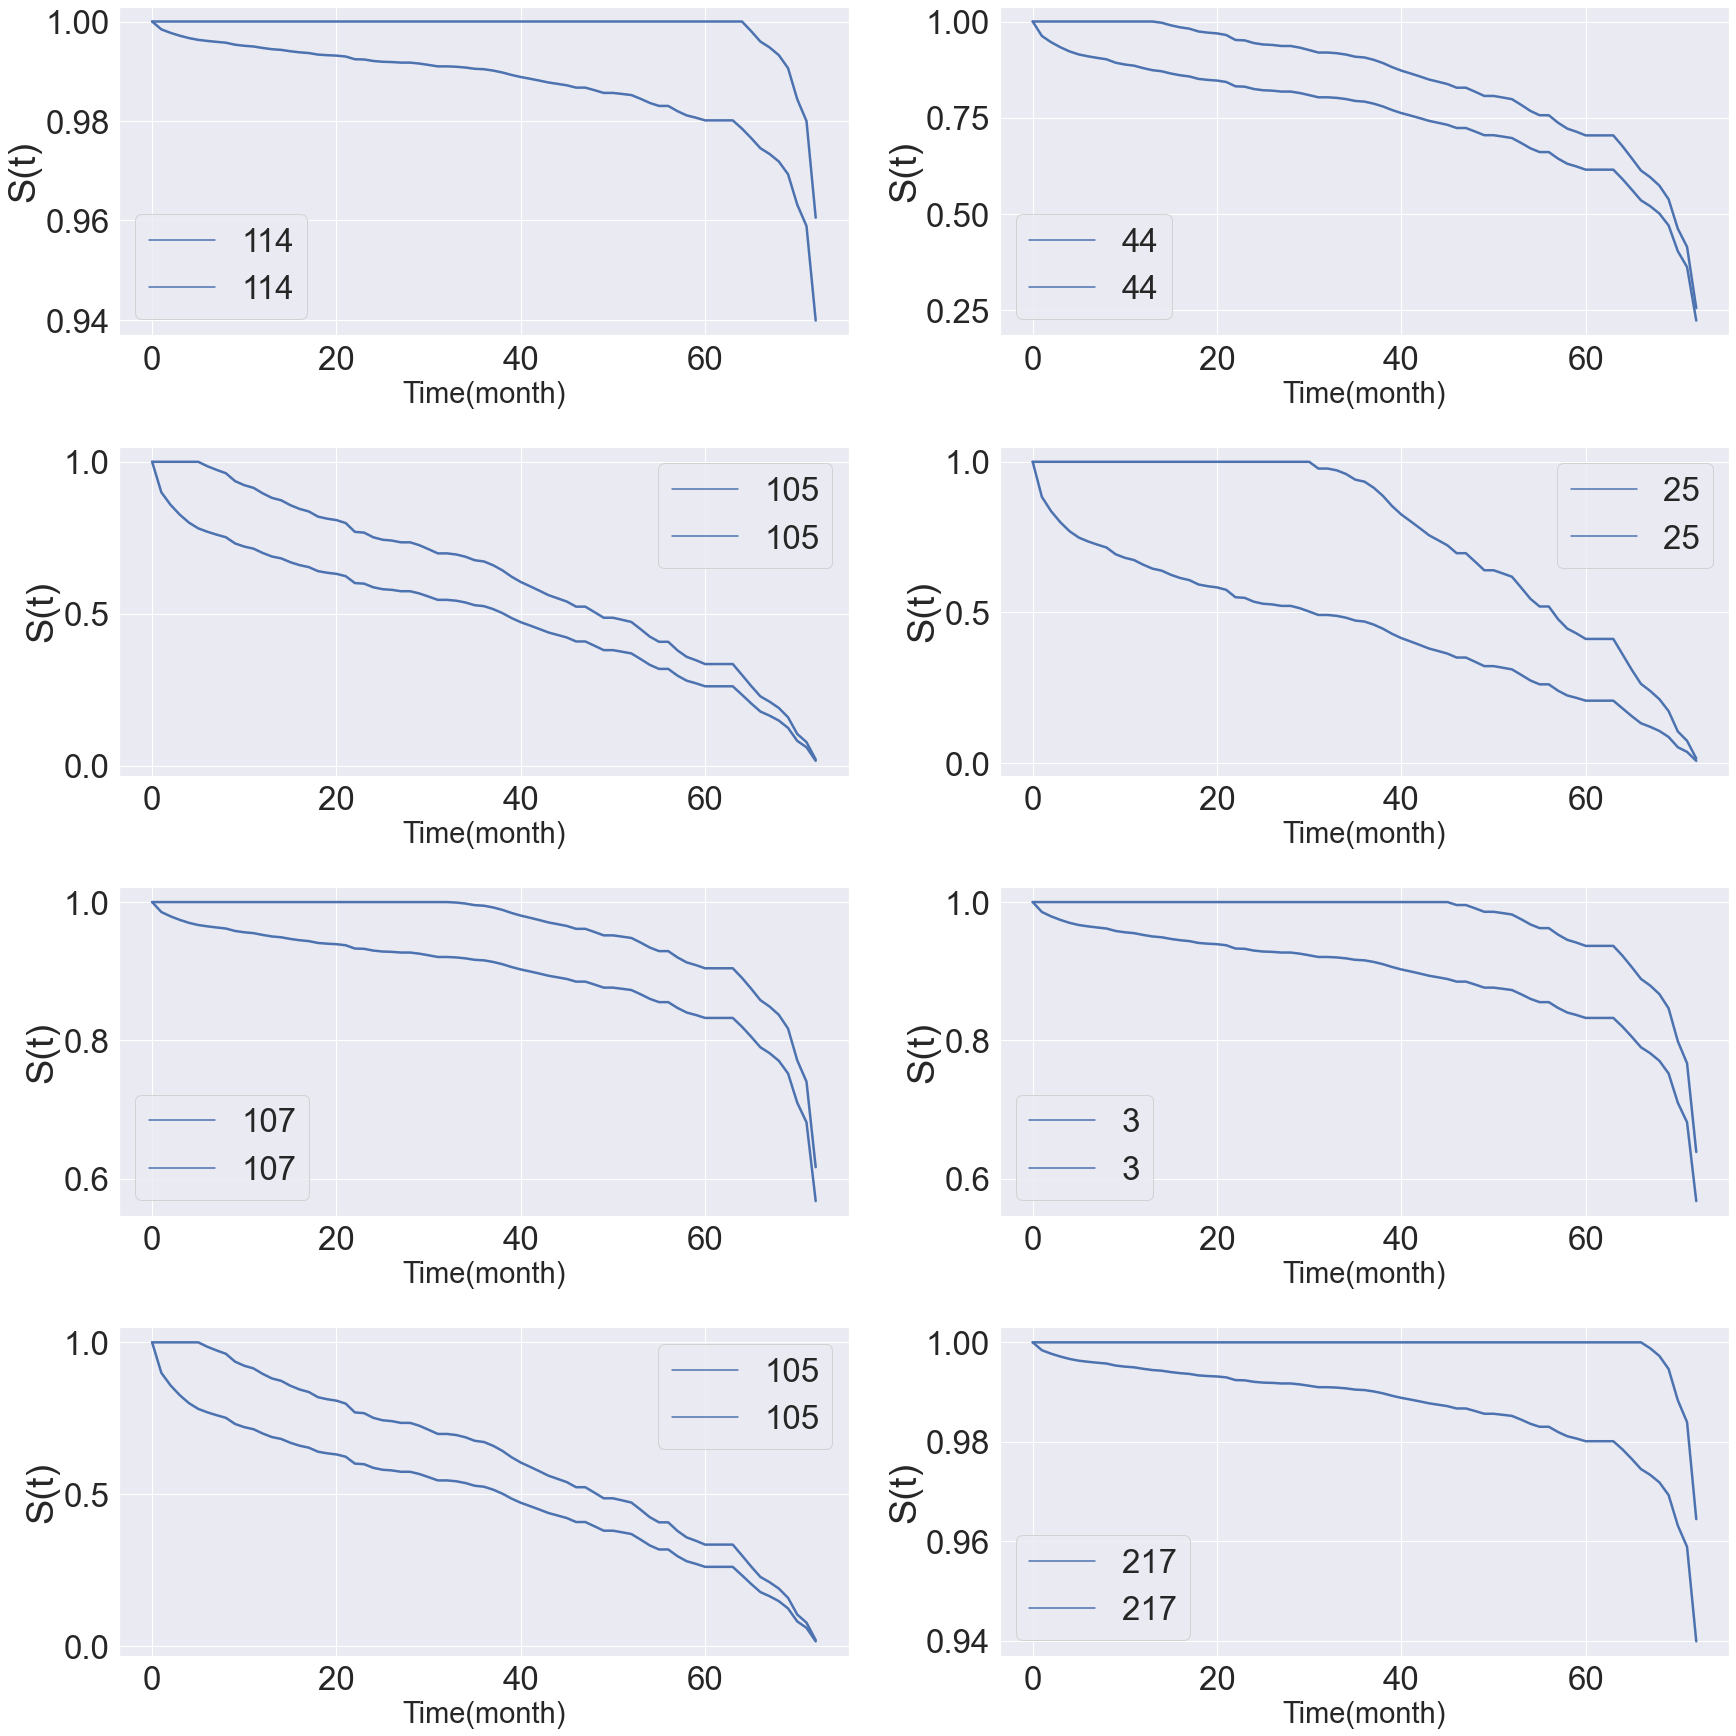

In [66]:
import random as rnd
fig , axes = plt.subplots(nrows = 6, ncols = 2, figsize = ((25,25)))
sns.set(font_scale = 3)

count = 1
for i in range(4*2):
      plt.subplot(4,2, count);
      rndm_customer = rnd.sample(range(1, unconditioned_sf.shape[0]), 1)
      un_con = sns.lineplot(data = unconditioned_sf.iloc[:, rndm_customer], color='blue', linewidth = 2.5);
      wn_cun = sns.lineplot(data = conditioned_sf.iloc[:, rndm_customer], color='red',\
                            linewidth = 2.5, linestyle ='--')
      count = count + 1
      un_con.set_xlabel("Time(month)", fontsize = 29)
      un_con.set_ylabel("S(t)", fontsize = 38)      
plt.tight_layout()        
plt.show()

In [67]:
from lifelines.utils import median_survival_times, qth_survival_times 
predictions_50 = median_survival_times(conditioned_sf) 
# This is the same, but you can change the fraction to get other 
# %tiles.  
# predictions_50 = qth_survival_times(.50, conditioned_sf)

In [68]:
values = predictions_50.T.join(df[['MonthlyCharges','tenure']])

m = values.loc[values[0.5] != np.inf, 0.5].max()
values[0.5].replace(np.inf,m,inplace=True)

values['RemainingValue'] = values['MonthlyCharges'] * (values[0.5] - values['tenure'])
values

,0.5,MonthlyCharges,tenure,RemainingValue
0,57.0,29.85,1,1671.60
1,72.0,56.95,34,2164.10
3,72.0,42.30,45,1142.10
7,53.0,29.75,10,1279.25
9,72.0,56.15,62,561.50
...,...,...,...,...
7017,72.0,20.65,51,433.65
7019,72.0,20.15,39,664.95
7020,72.0,19.20,12,1152.00
7030,56.0,20.05,2,1082.70


In [69]:
upgrades = ['MultipleLines_Yes', 'PaperlessBilling_Yes',
            'Contract_One year', 'Contract_Two year'] 
results_dict = {} 
for customer in values.index: 
    actual = df_enc.loc[[customer]]
    change = df_enc.loc[[customer]]     
    results_dict[customer] = [cph.predict_median(actual)] 
    for upgrade in upgrades: 
        change[upgrade] = 1 if list(change[upgrade]) == [0] else 0    
        results_dict[customer].append(cph.predict_median(change))      
        change[upgrade] = 1 if list(change[upgrade]) == [0] else 0  
results_df = pd.DataFrame(results_dict).T 
results_df.columns = ['baseline'] + upgrades
actions = values.join(results_df).drop([0.5], axis=1)


m = actions.loc[actions['baseline'] != np.inf, 'baseline'].max()
actions['baseline'].replace(np.inf,m,inplace=True)

m = actions.loc[actions['MultipleLines_Yes'] != np.inf, 'MultipleLines_Yes'].max()
actions['MultipleLines_Yes'].replace(np.inf,m,inplace=True)

m = actions.loc[actions['PaperlessBilling_Yes'] != np.inf, 'PaperlessBilling_Yes'].max()
actions['PaperlessBilling_Yes'].replace(np.inf,m,inplace=True)

m = actions.loc[actions['Contract_One year'] != np.inf, 'Contract_One year'].max()
actions['Contract_One year'].replace(np.inf,m,inplace=True)

m = actions.loc[actions['Contract_Two year'] != np.inf, 'Contract_Two year'].max()
actions['Contract_Two year'].replace(np.inf,m,inplace=True)

actions.head()

,MonthlyCharges,tenure,RemainingValue,baseline,MultipleLines_Yes,PaperlessBilling_Yes,Contract_One year,Contract_Two year
0,29.85,1,1671.60,54.0,69.0,59.0,72.0,70.0
1,56.95,34,2164.10,72.0,72.0,72.0,39.0,70.0
3,42.30,45,1142.10,72.0,72.0,72.0,39.0,70.0
7,29.75,10,1279.25,39.0,57.0,31.0,72.0,70.0
9,56.15,62,561.50,72.0,72.0,72.0,39.0,70.0


In [70]:
actions['MultipleLines_Yes Diff'] = ( 
    actions['MultipleLines_Yes'] - 
    actions['baseline']
) * actions['MonthlyCharges'] 

actions['PaperlessBilling_Yes Diff'] = ( 
    actions['PaperlessBilling_Yes'] - actions['baseline']
) * actions['MonthlyCharges'] 

actions['1yrContract Diff'] = ( 
    actions['Contract_One year'] - actions['baseline']
) * actions['MonthlyCharges']


actions['2yrContract Diff'] = ( 
    actions['Contract_Two year'] - actions['baseline']
) * actions['MonthlyCharges']


actions.head(30)

,MonthlyCharges,tenure,RemainingValue,baseline,MultipleLines_Yes,PaperlessBilling_Yes,Contract_One year,Contract_Two year,MultipleLines_Yes Diff,PaperlessBilling_Yes Diff,1yrContract Diff,2yrContract Diff
0,29.85,1,1671.60,54.0,69.0,59.0,72.0,70.0,447.75,149.25,537.30,477.60
1,56.95,34,2164.10,72.0,72.0,72.0,39.0,70.0,0.00,0.00,-1879.35,-113.90
3,42.30,45,1142.10,72.0,72.0,72.0,39.0,70.0,0.00,0.00,-1395.90,-84.60
7,29.75,10,1279.25,39.0,57.0,31.0,72.0,70.0,535.50,-238.00,981.75,922.25
9,56.15,62,561.50,72.0,72.0,72.0,39.0,70.0,0.00,0.00,-1852.95,-112.30
10,49.95,13,2597.40,54.0,69.0,59.0,72.0,70.0,749.25,249.75,899.10,799.20
23,59.90,58,838.60,72.0,72.0,72.0,72.0,69.0,0.00,0.00,0.00,-179.70
24,59.60,49,1251.60,59.0,70.0,54.0,72.0,70.0,655.60,-298.00,774.80,655.60
25,55.30,30,1493.10,31.0,53.0,39.0,72.0,70.0,1216.60,442.40,2267.30,2156.70
28,90.25,72,0.00,72.0,72.0,72.0,72.0,69.0,0.00,0.00,0.00,-270.75


In [71]:
from sklearn.metrics import brier_score_loss
brier_score_loss( cph_test['Churn_Yes'], 1 - np.array(cph.predict_survival_function(cph_test).loc[13]), \
                 pos_label=1 
)

0.22968345658999448

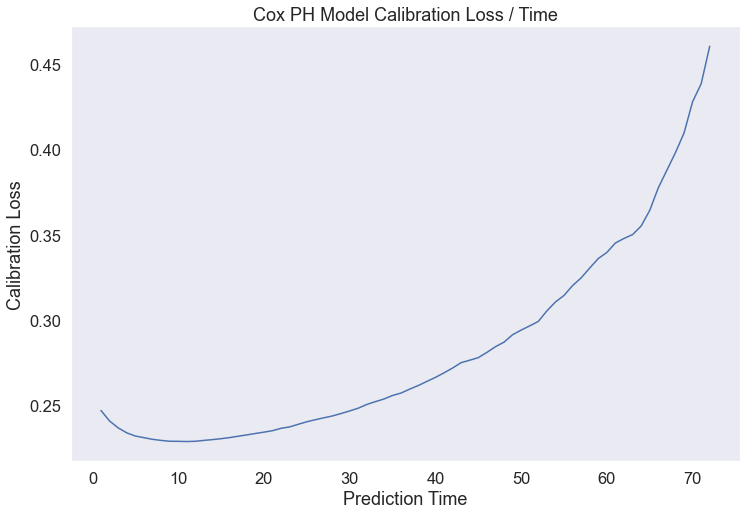

In [72]:
sns.set(font_scale = 1.5)

loss_dict = {} 
for i in range(1,73): 
    score = brier_score_loss( 
        cph_test['Churn_Yes'], 1 -    
        np.array(cph.predict_survival_function(cph_test).loc[i]),   
        pos_label=1 ) 
    loss_dict[i] = [score] 
loss_df = pd.DataFrame(loss_dict,).T 

loss_df
loss_df[0].head()

fig, ax = plt.subplots(figsize=(12, 8)) 
ax.plot(loss_df.index, loss_df[0]) 
ax.set(xlabel='Prediction Time', ylabel='Calibration Loss', title='Cox PH Model Calibration Loss / Time') 
ax.grid() 
plt.show()